# Implémentez un modèle de scoring

*Notebook modélisation - simulations*

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

**Mission :**

- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

- Analyser les features qui contribuent le plus au modèle, d’une manière générale (feature importance globale) et au niveau d’un client (feature importance locale), afin, dans un soucis de transparence, de permettre à un chargé d’études de mieux comprendre le score attribué par le modèle.

- Mettre en production le modèle de scoring de prédiction à l’aide d’une API et réaliser une interface de test de cette API.

- Mettre en œuvre une approche globale MLOps de bout en bout, du tracking des expérimentations à l’analyse en production du data drift.
    + Dans le notebook d’entraînement des modèles, générer à l’aide de MLFlow un tracking d'expérimentations
    + Lancer l’interface web 'UI MLFlow" d'affichage des résultats du tracking
    + Réaliser avec MLFlow un stockage centralisé des modèles dans un “model registry”
    + Tester le serving MLFlow
    + Gérer le code avec le logiciel de version Git
    + Partager le code sur Github pour assurer une intégration continue
    + Utiliser Github Actions pour le déploiement continu et automatisé du code de l’API sur le cloud
    + Concevoir des tests unitaires avec Pytest (ou Unittest) et les exécuter de manière automatisée lors du build réalisé par Github Actions

## 1 - Préparer l'environnement d'expérimentation

### 1.1 - Imports

In [5]:
import mlflow
import mlflow.tracking
from mlflow.models import infer_signature

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, make_scorer, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # Pipeline de imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler

from contextlib import contextmanager
from collections import Counter
import time
import timeit

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("mlflow version", mlflow.__version__)
print("sklearn version", sklearn.__version__)

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 200
pd.options.display.max_columns = 130

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
mlflow version 2.20.1
sklearn version 1.6.1


### 1.2 - Lancement du serveur MLFlow

Dans le terminal de Powershell Prompt d'Anaconda, lancer cette instruction :

mlflow server --host 127.0.0.1 --port 5000 --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns

Cette commande permet de :
- Stocker les métadonnées du Model Registry dans une base de données locale SQLite.
- Stocker les artefacts (modèles, fichiers) en local.

### 1.3 - Initialisation du Tracking MLFlow de test

In [7]:
import os

# Ignorer Git
os.environ['GIT_PYTHON_REFRESH'] = 'quiet'

# Vérification si la variable d'environnement est bien définie
print(os.environ.get('GIT_PYTHON_REFRESH'))

# Définir le serveur de tracking (local ou distant) - ici local
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Démarrer une nouvelle expérimentation
mlflow.set_experiment("simulation_scoring_credit_5")

quiet


2025/02/17 12:01:54 INFO mlflow.tracking.fluent: Experiment with name 'simulation_scoring_credit_5' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/admin/mlruns/13', creation_time=1739790114736, experiment_id='13', last_update_time=1739790114736, lifecycle_stage='active', name='simulation_scoring_credit_5', tags={}>

### 1.4 - Enregistrer le modèle et ses métadonnées dans MLFlow

Créons une fonction :

In [144]:
def tracking_mlflow(tag, model, params, metrics, registered_model_name, X_train):

    # Démarrer une expérimentation dans MLflow
    with mlflow.start_run():
        try:
        
            # Log the hyperparameters
            mlflow.log_params(params)
            
            # Loguer les métriques
            for key, value in metrics.items():
                mlflow.log_metric(key, value)
                #mlflow.log_metric("accuracy", accuracy)
                #mlflow.log_metric("auc", auc)
        
            # Set a tag that we can use to remind ourselves what this run was for
            mlflow.set_tag(tag[0], tag[1])
        
            # Infer the model signature
            signature = infer_signature(X_train, model.predict(X_train))
            
            # Loguer le modèle
            model_info = mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path="iris_model",
                signature=signature,
                input_example=X_train[:5],
                registered_model_name=registered_model_name,
            )
    
            for key, value in metrics.items():
                print(key, ":" , value)

        except Exception as e:
            print(f"❌ Erreur dans MLflow : {e}")

        finally:
            mlflow.end_run()  # Assure que la run est bien fermée
    
    print(f"Modèle enregistré en version {model_info.mlflow_version}")
    
    return model_info

def save_model_mlflow(grid_search, model_name, metrics):
    elapsed = round(timeit.default_timer() - start_time, 3)
    print("📂 Durée depuis le début : ", elapsed, " - Fin entraînement",  model_name, "...")
    
    # Meilleur modèle trouvé
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Extraction des scores
    results = grid_search.cv_results_
    best_index = grid_search.best_index_
    
    # Préparation des métriques à logger
    metrics_log = {
        "best_business_score": grid_search.best_score_,
        "mean_fit_time": round(results["mean_fit_time"][best_index], 3),
    }
    
    # Ajout des autres scores
    for metric in metrics.keys():
        metrics_log[f"mean_{metric}"] = results[f"mean_test_{metric}"][best_index]
    
    # Définition des tags MLflow
    tag = ("model_type", model_name)
    
    # Nom du modèle à enregistrer dans MLflow
    registered_model_name = model_name
    
    elapsed = round(timeit.default_timer() - start_time, 3)
    print("📂 Durée depuis le début : ", elapsed, " - Début tracking MLFlow",  model_name, "...")
    
    # Appel de la fonction tracking_mlflow
    tracking_mlflow(tag, best_model, best_params, metrics_log, registered_model_name, X_train)
    
    elapsed = round(timeit.default_timer() - start_time, 3)
    print("📂 Durée depuis le début : ", elapsed, " - Fin tracking MLFlow",  model_name, "...")
    
    print(f"✅ Fin traitement",  model_name)

### 1.5 - Lancement de l'UI

Pour  la visualisation et la comparaison des expérimentations, ainsi que le stockage de manière centralisée des modèles.

Cliquer sur ce lien : http://127.0.0.1:5000/

### 1.6 - Charger les données issues du feature engineering

In [11]:
df = pd.read_csv('C:/Users/admin/Documents/Projets/Projet_7/data_projet/cleaned/data.csv')

print('Training data shape: ', df.shape)
df.head()

Training data shape:  (307507, 395)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,...,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_nan
0,100002.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0000,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.0000,0.0149,2.0,2.0,2.0,2.0,-1134.0,0.0,...,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,100003.0,0.0,0.0,270000.0,1293502.5,35698

In [12]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [13]:
# Missing values statistics
missing_values = missing_values_table(df)
missing_values.head(130)

Your selected dataframe has 395 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Bien. Aucune valeur manquante.

### 1.7 - Créer les fonctions communes

In [146]:
def print_result_CV_as_dataframe(grid_search, scoring):

    # Liste pour stocker les résultats
    results = []
    
    # Affichage des résultats de la validation croisée
    print("Résultats de la validation croisée :")
    
    for score_name in scoring.keys():
        for mean, std, params, mean_fit_time in zip(
            grid_search.cv_results_[f'mean_test_{score_name}'],  # Score moyen pour chaque métrique
            grid_search.cv_results_[f'std_test_{score_name}'],   # Écart-type du score
            grid_search.cv_results_['params'],                   # Valeurs des hyperparamètres
            grid_search.cv_results_['mean_fit_time']             # Temps moyen d'entraînement
        ):
            # Ajout des résultats sous forme de dictionnaire
            results.append({
                "score_name": score_name,
                "mean_score": mean,
                "std_score": std,
                "params": params,
                "mean_fit_time": mean_fit_time
            })

    # Transformation en DataFrame
    df_results = pd.DataFrame(results)

    # Convertir 'params' en string pour affichage correct
    df_results['params'] = df_results['params'].apply(str)

    # Transformation avec pivot pour structurer les données
    df_results = df_results.pivot(
        index='params',                        # Les paramètres deviennent l'index
        columns='score_name',                   # Les métriques deviennent des colonnes
        values=['mean_score', 'mean_fit_time']  # Les valeurs à afficher
    ).reset_index()

    # Aplatir les colonnes multi-indexées
    df_results.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_results.columns.values]

    # Identifier la meilleure métrique de tri (prendre la première de `scoring`)
    main_metric = list(scoring.keys())[0]  # Prend la première métrique comme référence
    main_metric_col = f"mean_score_{main_metric}"

    # Trier le DataFrame selon cette métrique (du plus grand au plus petit)
    df_results.sort_values(by=main_metric_col, ascending=False, inplace=True)

    # Suppression des colonnes superflues
    fit_time_columns = [col for col in df_results.columns if "mean_fit_time_" in col and col != "mean_fit_time"]
    df_results.drop(columns=fit_time_columns, inplace=True)

    # Réinitialisation de l'index
    df_results = df_results.reset_index(drop=True)

    return df_results

## 2 - Créer un score métier pour l'entraînement des modèles

### 2.1 - Créer le score métier et le score pour le seuil

In [166]:
# Calculer le coût
def calculate_errors_cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return 10 * fn + fp

# On transforme le score en négatif pour que GridSearchCV le minimise
neg_business_scorer = make_scorer(calculate_errors_cost, greater_is_better=False)

# Scorer pour renvoyer le seuil utilisé
def get_threshold_score(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    return threshold  # Retourne le seuil utilisé

threshold_scorer = make_scorer(get_threshold_score, needs_proba=True)

Test de la fonction : 

In [16]:
y_test_sample = [0, 1, 1, 0, 1, 0, 0, 1, 1, 0]
y_pred_sample = [0, 0, 1, 0, 1, 0, 1, 1, 1, 0]

print("Résultat de calculate_errors_cost:", calculate_errors_cost(y_test_sample, y_pred_sample))

Résultat de calculate_errors_cost: 11


### 2.2 - Créer une classe pour ajouter le seuil dans le GridSearchCV

Le seuil optimal est la valeur à partir de laquelle on décide si un client doit obtenir ou non un crédit, basé sur la probabilité prédite par le modèle. Le but est de trouver un seuil qui minimise le coût métier, c'est-à-dire le coût total des erreurs de prédiction en tenant compte des faux positifs (FP) et des faux négatifs (FN), où les faux négatifs sont 10 fois plus coûteux.

Le seuil optimal est celui qui donne le coût total le plus bas.

Le seuil sera ajouté dans le param_grid en entrée du GridSearchCV. On ajustera ainsi le seuil de décision en même temps que les autres hyperparamètres.

In [152]:
# Classe ThresholdClassifier pour appliquer un seuil sur les probabilités
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model, threshold=0.5):
        self.base_model = base_model
        self.threshold = threshold

    def fit(self, X, y):
        self.base_model.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.base_model.predict_proba(X)

    def predict(self, X):
        # Applique le seuil sur les probabilités
        y_scores = self.predict_proba(X)[:, 1]  # Prend la probabilité pour la classe positive
        return (y_scores >= self.threshold).astype(int)

## 3 - Simuler et comparer plusieurs modèles avec undersampling

Pour corriger le déséquilibre entre le nombre de bons et de moins bons clients, 3 solutions peuvent être utilisées :

- SMOTE : qui permet de génèrer des exemples synthétiques pour la classe minoritaire, en créant de nouvelles instances en interpolant entre les exemples existants de la classe minoritaire.

  -- j'ai commencé avec cette méthode, mais les temps de traitement étaient trop long, et faisait planter mon PC à cause des 300 000 lignes qu'il générère pour le réquilibrage. 

- Ou par ajustement des poids des classes par paramétrage des modèles de type "class_weight"
  
    -- Logistic Regression avec class_weight="balanced"
  
  -- Random Forest avec class_weight="balanced"
  
  -- Decision Tree avec class_weight="balanced"
  
  -- XGBoost avec scale_pos_weight
  
  -- LightGBM avec is_unbalance=True ou scale_pos_weight

- Ou par Undersampling (sous-échantillonage) : réduire la taille de la classe majoritaire pour équilibrer les proportions. L'avantage c'est qu'elle réduit la taille du dataset, ce qui permet un gain de rapidité pour des premières simulation. Je vais donc commencer les simulations avec cette méthodes, pour faire une 1ere sélection des modèles, et ensuite je travaillerais avec SMOTE (oversampling) pour l'affinage.

### 3.1 - Préparer le dataset avec undersampling

Distribution après sous-échantillonnage : Counter({0.0: 24825, 1.0: 24825})
taille X_train :  (39720, 394)
taille y_train :  (39720,)
taille X_test :  (9930, 394)
taille y_test :  (9930,)


<Axes: ylabel='Frequency'>

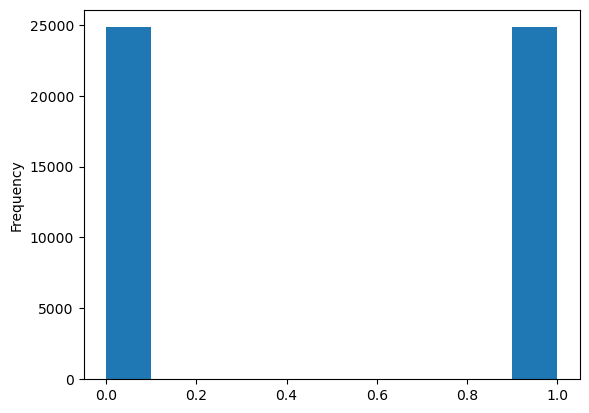

In [27]:
# Définition des features et de la target
X = df.drop(columns=["TARGET"])  # Features
y = df["TARGET"]  # Variable cible

# sous-échantillonage
X_resampled, y_resampled = RandomUnderSampler().fit_resample(X, y)
print(f"Distribution après sous-échantillonnage : {Counter(y_resampled)}")

# Centrage et réduction des données
X_scale = StandardScaler().fit_transform(X_resampled)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scale, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print("taille X_train : ", X_train.shape)
print("taille y_train : ", y_train.shape)
print("taille X_test : ", X_test.shape)
print("taille y_test : ", y_test.shape)

y_resampled.plot.hist()

In [168]:
# Scorer personnalisé pour calculer l'AUC (besoin des probabilités)
def auc_scorer(y_true, y_proba):
    return roc_auc_score(y_true, y_proba)

# `needs_proba=True` pour utiliser `predict_proba`
auc_scorer = make_scorer(auc_scorer, needs_proba=True)

# Scorers personnalisés
metrics = {
    "business_score": neg_business_scorer,
    "threshold_scorer": threshold_scorer,
    "accuracy": make_scorer(accuracy_score),  # Accuracy classique,
    "auc": auc_scorer,
    "f1_macro": make_scorer(f1_score, average="macro"),  # F1-score macro
}

### 3.2 - Simuler avec DumyClassifier (Baseline)

In [53]:
# Scorers personnalisés pour le dummyClassifier
metrics_dummy = {
    "accuracy": make_scorer(accuracy_score),  # Accuracy classique,
    "f1_macro": make_scorer(f1_score, average="macro"),  # F1-score macro
}

In [55]:
# Définition des paramètres à tester
param_grid = {
    'strategy': ['most_frequent']
}

In [57]:
print("📂 Lancement du traitement DummyClassifier...")
start_time = timeit.default_timer()

# Initialisation du modèle
dummy_clf = DummyClassifier()

# GridSearchCV avec plusieurs scores
grid_search = GridSearchCV(dummy_clf, param_grid, scoring=metrics_dummy, refit="accuracy", cv=5, n_jobs=1, verbose=1)

# Exécution de la recherche
grid_search.fit(X_train, y_train)

save_model_mlflow(grid_search, "DummyClassifier_gridSearchCV", metrics)

📂 Lancement du traitement DummyClassifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
📂 Durée depuis le début :  0.642  - Fin entraînement DummyClassifier...
📂 Durée depuis le début :  0.643  - Début tracking MLFlow DummyClassifier...


Registered model 'DummyClassifier_GridSearch' already exists. Creating a new version of this model...
2025/02/15 19:17:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DummyClassifier_GridSearch, version 2
Created version '2' of model 'DummyClassifier_GridSearch'.


accuracy : 0.5
mean_fit_time : 0.075
mean_accuracy : 0.5
mean_f1_macro : 0.3333333333333333
🏃 View run grandiose-snipe-950 at: http://127.0.0.1:5000/#/experiments/11/runs/3225b54678e14f1c82903004181a4e87
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/11
Modèle enregistré en version 2.20.1
📂 Durée depuis le début :  28.531  - Fin tracking MLFlow DummyClassifier...
✅ Fin traitement DummyClassifier


'\n# Affichage des résultats\nprint("Meilleure stratégie :", grid_search.best_params_["strategy"])\nprint("Meilleur business score :", grid_search.best_score_)\n\n# Affichage des autres scores\nfor metric in metrics.keys():\n    mean_score = results[f"mean_test_{metric}"][grid_search.best_index_]\n    print(f"{metric} (moyenne) :", mean_score)\n\nmean_fit_time = results["mean_fit_time"][grid_search.best_index_]\nprint(f"temps moyen d\'entraînement :", round(mean_fit_time,3))\n'

### 3.3 - Simuler avec LogisticRegression

In [64]:
print("📂 Lancement du traitement LogisticRegression...")
start_time = timeit.default_timer()

# Initialisation du modèle
base_model = LogisticRegression(solver="liblinear", random_state=42)  # Utilisation d'un solver adapté

# Créer un wrapper pour intégrer le seuil
custom_model = ThresholdClassifier(base_model=base_model)

param_grid = {
    "base_model__C": [0.01, 0.1, 1],  # Régularisation
    "threshold": [0.0, 0.2, 0.3, 0.5, 0.6]  # Différents seuils à tester
}

# GridSearchCV avec plusieurs scores
grid_search = GridSearchCV(custom_model, param_grid, scoring=metrics, refit="business_score", cv=5, n_jobs=-1, verbose=1)

# Exécution de la recherche
grid_search.fit(X_train, y_train)

save_model_mlflow(grid_search, "LogisticRegression_gridSearchCV", metrics)

📂 Lancement du traitement LogisticRegression...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
📂 Durée depuis le début :  751.821  - Fin entraînement LogisticRegression...
📂 Durée depuis le début :  751.826  - Début tracking MLFlow LogisticRegression...


Registered model 'LogisticRegression_GridSearch' already exists. Creating a new version of this model...
2025/02/17 12:45:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression_GridSearch, version 9


best_business_score : -3972.0
mean_fit_time : 26.844
mean_business_score : -3972.0
mean_accuracy : 0.5
mean_auc : nan
mean_f1_macro : 0.3333303860983726
🏃 View run rogue-snake-848 at: http://127.0.0.1:5000/#/experiments/13/runs/7ed34ecd89ca405ba2e98432d35ed42c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/13
Modèle enregistré en version 2.20.1
📂 Durée depuis le début :  764.123  - Fin tracking MLFlow LogisticRegression...
✅ Fin traitement LogisticRegression


Created version '9' of model 'LogisticRegression_GridSearch'.


In [66]:
print_result_CV_as_dataframe(grid_search, metrics)

Résultats de la validation croisée :


,params_,mean_score_accuracy,mean_score_auc,mean_score_business_score,mean_score_f1_macro
0,"{'base_model__C': 0.01, 'threshold': 0.0}",0.500000,NaN,-3972.0,0.333330
1,"{'base_model__C': 0.1, 'threshold': 0.0}",0.500000,NaN,-3972.0,0.333330
2,"{'base_model__C': 1, 'threshold': 0.0}",0.500000,NaN,-3972.0,0.333330
3,"{'base_model__C': 0.01, 'threshold': 0.2}",0.583359,NaN,-4530.2,0.511943
4,"{'base_model__C': 0.1, 'threshold': 0.2}",0.588343,NaN,-4595.0,0.521134
5,"{'base_model__C': 1, 'threshold': 0.2}",0.589703,NaN,-4622.0,0.523717
6,"{'base_model__C': 0.01, 'threshold': 0.3}",0.644612,NaN,-6149.6,0.618348
7,"{'base_model__C': 0.1, 'threshold': 0.3}",0.646626,NaN,-6279.4,0.621791
8,"{'base_model__C': 1, 'threshold': 0.3}",0.647155,NaN,-6318.4,0.622715
9,"{'base_model__C': 1, 'threshold': 0.5}",0.698464,NaN,-13134.2,0.698463


**Traçons l'histogramme des probabilités:**

Un bon moyen d'analyser les performances d'un modèle de classification consiste à tracer l'histogramme des probabilités des prédictions.

<Axes: ylabel='Count'>

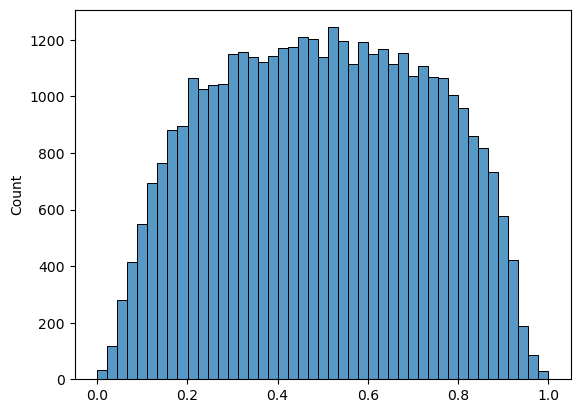

In [67]:
# Récupérer les probabilités prédites sur un jeu d'entraînement
y_proba_train = best_model.predict_proba(X_train)[:,1]

# Afficher l'histogramme
sns.histplot(y_proba_train)

<Axes: ylabel='Count'>

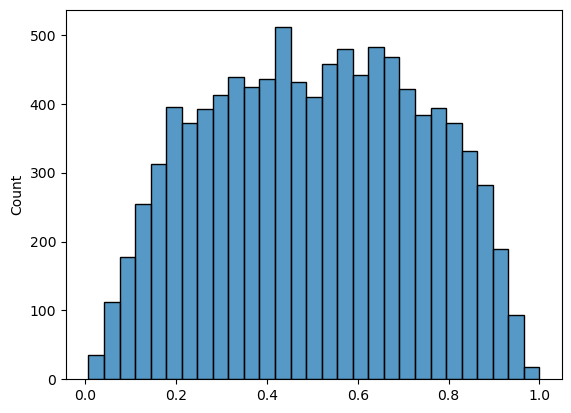

In [68]:
# Récupérer les probabilités prédites sur un jeu de test
y_proba_test = best_model.predict_proba(X_test)[:,1]

# Afficher l'histogramme
sns.histplot(y_proba_test)

In [84]:
thresholds = [0.0, 0.2, 0.3, 0.5, 0.6]
for t in thresholds:
    y_pred = (y_proba_test >= t).astype(int)
    
    # Calcul des scores
    cost = calculate_errors_cost(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    
    # Vérifier si AUC est NaN
    try:
        auc = roc_auc_score(y_test, y_proba)
    except ValueError:
        auc = "NaN"

    print(f"Threshold={t} | Business Score={cost} | Accuracy={acc} | F1={f1} | AUC={auc}")

Threshold=0.0 | Business Score=4965 | Accuracy=0.5 | F1=0.3333333333333333 | AUC=0.7699087570698819
Threshold=0.2 | Business Score=5566 | Accuracy=0.5835850956696879 | F1=0.5113899068096425 | AUC=0.7699087570698819
Threshold=0.3 | Business Score=7405 | Accuracy=0.6431017119838872 | F1=0.6149272027807239 | AUC=0.7699087570698819
Threshold=0.5 | Business Score=15603 | Accuracy=0.704833836858006 | F1=0.7047942435301966 | AUC=0.7699087570698819
Threshold=0.6 | Business Score=22517 | Accuracy=0.6883182275931521 | F1=0.6835334624413134 | AUC=0.7699087570698819


Plus le seuil augmente, plus le score métier se dégrade !
C'est normal, car le score métier est une fonction de coût (nombre de FN et FP), et GridSearchCV minimise ce score.

Pourquoi un seuil de 0.0 ?
Si threshold=0.0, le modèle prédit toujours 1, ce qui donne :
- FN = 0 (aucune classe 1 mal classée).
- FP = Beaucoup, mais le calculate_errors_cost pèse 10x plus les FN que les FP.

Donc, minimiser 10 * FN + FP pousse le modèle à tout prédire en positif (éviter les FN à tout prix).

**Refaisons une simulation avec un seuil fixe**

In [ ]:
print("📂 Lancement du traitement LogisticRegression...")
start_time = timeit.default_timer()

# Initialisation du modèle
base_model = LogisticRegression(solver="liblinear", random_state=42)  # Utilisation d'un solver adapté

# Créer un wrapper pour intégrer le seuil
custom_model = ThresholdClassifier(base_model=base_model)

# Paramètres à tester dans GridSearchCV
param_grid = {
    "base_model__C": [0.01, 0.1, 1],  # Régularisation
    "threshold": [0.3, 0.4, 0.5]  # Différents seuils à tester
}

# GridSearchCV avec plusieurs scores
grid_search = GridSearchCV(custom_model, param_grid, scoring=metrics, refit="business_score", cv=5, n_jobs=-1, verbose=1)

# Exécution de la recherche
grid_search.fit(X_train, y_train)

save_model_mlflow(grid_search, "LogisticRegression_gridSearchCV", metrics)

📂 Lancement du traitement LogisticRegression...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [ ]:
print_result_CV_as_dataframe(grid_search, metrics)

In [ ]:
thresholds = [0.0, 0.2, 0.3, 0.5, 0.6]
for t in thresholds:
    y_pred = (y_proba_test >= t).astype(int)
    
    # Calcul des scores
    cost = calculate_errors_cost(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    
    # Vérifier si AUC est NaN
    try:
        auc = roc_auc_score(y_test, y_proba)
    except ValueError:
        auc = "NaN"

    print(f"Threshold={t} | Business Score={cost} | Accuracy={acc} | F1={f1} | AUC={auc}")

In [162]:
# Calcul du coût d'erreurs pour le business score
def calculate_errors_cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return 10 * fn + fp  # Pénalité de 10 pour FN

# Scorer pour minimiser le business score (négatif pour que GridSearchCV le minimise)
neg_business_scorer = make_scorer(calculate_errors_cost, greater_is_better=False)

# Scorer personnalisé pour calculer l'AUC (besoin des probabilités)
def auc_scorer(y_true, y_proba):
    return roc_auc_score(y_true, y_proba)

# ⚠️ Correction : `needs_proba=True` pour utiliser `predict_proba`
auc_scorer = make_scorer(auc_scorer, needs_proba=True)

# ⚠️ Correction : Scorer pour retourner la moyenne des seuils utilisés
def get_threshold_score(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    return threshold  # Retourne le seuil utilisé

threshold_scorer = make_scorer(get_threshold_score, needs_proba=True)

# Classe ThresholdClassifier pour appliquer un seuil sur les probabilités
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model, threshold=0.5):
        self.base_model = base_model
        self.threshold = threshold

    def fit(self, X, y):
        self.base_model.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.base_model.predict_proba(X)

    def predict(self, X):
        # Applique le seuil sur les probabilités
        y_scores = self.predict_proba(X)[:, 1]  # Probabilité de la classe positive
        return (y_scores >= self.threshold).astype(int)

# Scorers personnalisés
metrics = {
    "business_score": neg_business_scorer,
    "threshold_scorer": threshold_scorer,  # ⚠️ Correction
    "accuracy": make_scorer(accuracy_score),
    "auc": auc_scorer,  # ⚠️ Correction : `needs_proba=True`
    "f1_macro": make_scorer(f1_score, average="macro"),
}

# Afficher les résultats sous forme de DataFrame
def print_result_CV_as_dataframe(grid_search, scoring):
    results = []
    for score_name in scoring.keys():
        for mean, std, params, mean_fit_time in zip(
            grid_search.cv_results_[f'mean_test_{score_name}'],
            grid_search.cv_results_[f'std_test_{score_name}'],
            grid_search.cv_results_['params'],
            grid_search.cv_results_['mean_fit_time']
        ):
            results.append({
                "score_name": score_name,
                "mean_score": mean,
                "std_score": std,
                "params": params,
                "mean_fit_time": mean_fit_time
            })

    df_results = pd.DataFrame(results)
    df_results['params'] = df_results['params'].apply(str)
    
    df_results = df_results.pivot(
        index='params',
        columns='score_name',
        values=['mean_score', 'mean_fit_time']
    ).reset_index()

    df_results.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_results.columns.values]

    main_metric = list(scoring.keys())[0]
    main_metric_col = f"mean_score_{main_metric}"

    df_results.sort_values(by=main_metric_col, ascending=False, inplace=True)
    fit_time_columns = [col for col in df_results.columns if "mean_fit_time_" in col and col != "mean_fit_time"]
    df_results.drop(columns=fit_time_columns, inplace=True)

    df_results = df_results.reset_index(drop=True)
    return df_results

# Chargement des données (X_train, y_train) – ici tu peux charger tes données
# Exemple : X_train, y_train = load_data()

# Initialisation du modèle
base_model = LogisticRegression(solver="liblinear", random_state=42)

# Créer un wrapper pour intégrer le seuil
custom_model = ThresholdClassifier(base_model=base_model)

# Paramètres à tester dans GridSearchCV
param_grid = {
    "base_model__C": [0.01, 0.1, 1],
    "threshold": [0.3, 0.4, 0.5]
}

# GridSearchCV avec plusieurs scores
grid_search = GridSearchCV(custom_model, param_grid, scoring=metrics, refit="business_score", cv=5, n_jobs=-1, verbose=1)

# Exécution de la recherche
start_time = timeit.default_timer()
grid_search.fit(X_train, y_train)
print(f"Temps d'exécution : {timeit.default_timer() - start_time} secondes.")

# Affichage des résultats
df_results = print_result_CV_as_dataframe(grid_search, metrics)
print(df_results)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Temps d'exécution : 492.24696059996495 secondes.
Résultats de la validation croisée :
                                     params_  mean_score_accuracy  \
0  {'base_model__C': 0.01, 'threshold': 0.3}             0.644612   
1   {'base_model__C': 0.1, 'threshold': 0.3}             0.646626   
2     {'base_model__C': 1, 'threshold': 0.3}             0.647155   
3  {'base_model__C': 0.01, 'threshold': 0.4}             0.684819   
4   {'base_model__C': 0.1, 'threshold': 0.4}             0.686480   
5     {'base_model__C': 1, 'threshold': 0.4}             0.686430   
6     {'base_model__C': 1, 'threshold': 0.5}             0.698464   
7   {'base_model__C': 0.1, 'threshold': 0.5}             0.698313   
8  {'base_model__C': 0.01, 'threshold': 0.5}             0.696274   

   mean_score_auc  mean_score_business_score  mean_score_f1_macro  \
0             NaN                    -6149.6             0.618348   
1             NaN        

In [ ]:
DummyClassifier, Regression Logistique, Random Forest, Decision Tree, XGBoost, Lightgbm

Courbe Roc, AUC, f1-score, precision, recall, time

matrice de confusion